# Supplemental Figure S21: Correlation plots for distance and reactivity for A-G pairs for the engineered 1x1 and 2x2 two-way junctions with low hydrogen bonds in the new dataset 

# Setup

## imports

In [12]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from dms_3d_features.plotting import *

## extra functions

In [27]:
def load_dict_from_pickle(filename):
    """
    Load a dictionary from a pickle file.

    Args:
        filename (str): The path to the pickle file.

    Returns:
        dict: The loaded dictionary.
    """
    with open(filename, "rb") as f:
        return pickle.load(f)


def parse_motif_indentifier(motif_name: str) -> tuple:
    """
    parse a name such as HAIRPIN-1-CGG-7PWO-1
    into a tuple of (mtype, msize, msequence, pdb_id)
    """
    spl = motif_name.split("-")
    mtype = spl[0]
    # Count how many elements are numbers (size components)
    size_parts = []
    i = 1
    while i < len(spl) and spl[i].isdigit():
        size_parts.append(int(spl[i]))
        i += 1
    msize = "-".join([str(p) for p in size_parts])
    msequence = "-".join(spl[i:-2])
    pdb_id = spl[-2]
    return (mtype, msize, msequence, pdb_id)


def add_motif_indentifier_columns(df: pd.DataFrame, name_col: str) -> pd.DataFrame:
    """Add columns for each component of a motif name.

    Args:
        df: DataFrame containing motif names
        name_col: Name of column containing motif names

    Returns:
        DataFrame with new columns for motif type, size, sequence and PDB ID
    """
    components = df[name_col].apply(parse_motif_indentifier)
    df["mtype"] = components.apply(lambda x: x[0])
    df["msize"] = components.apply(lambda x: x[1])
    df["msequence"] = components.apply(lambda x: x[2])
    df["pdb_id"] = components.apply(lambda x: x[3])
    return df


def combine_old_and_new_data(df_old, df_new, data_type="reactivity"):
    """
    Combine old and new dataframes on the 'motif_name' column.

    Parameters:
    """
    df_old = df_old.copy()
    df_new = df_new.copy()
    if data_type == "reactivity":
        df_new.rename(columns={"ln_reactivity": "ln_r_data_mean"}, inplace=True)
        df = pd.concat([df_old, df_new])
        return df
    else:
        df_new.rename(columns={"reactivity_ratio": "ln_r_data_mean"}, inplace=True)


def extract_pdb_id(pdb_path):
    """
    Extracts the PDB ID (e.g., '1UN6') from a path like 'data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0'.

    Args:
        pdb_path (str): The path string containing the PDB ID.

    Returns:
        str: The extracted PDB ID, or None if not found.
    """
    import re

    # Find the last part of the path
    last_part = pdb_path.split("/")[-1]
    # Search for a pattern like .1UN6. in the last part
    match = re.search(r"\.([0-9A-Za-z]{4})\.", last_part)
    if match:
        return match.group(1)
    # If not found, try to find a 4-character PDB ID anywhere in the string
    match = re.search(r"([0-9A-Za-z]{4})", last_part)
    if match:
        return match.group(1)
    return None


def get_best_fit_line(df, x_col, y_col):
    X = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    return model


def get_r2(x, y):
    """
    Calculate the coefficient of determination (R^2) for two variables.

    Args:
    x (array-like): The first variable.
    y (array-like): The second variable.

    Returns:
    float: The R^2 value, which represents the proportion of the variance in the dependent variable
           that is predictable from the independent variable.
    """
    return pearsonr(x, y)[0] ** 2

## load data

In [14]:
DATA_PATH = "../../data"
REVISION_PATH = "../../data/revisions"

In [15]:
df_pdb = pd.read_json(f"{REVISION_PATH}/new_structures/pdb_info.json")

df_corr_data = pd.read_csv(f"{DATA_PATH}/pdb-features/non_canonical_atom_distances.csv")
df_ratio_corr_data = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_with_ratio.csv"
)
df_corr_new_data = pd.read_csv(f"{REVISION_PATH}/new_structures/non_wc_distances.csv")
df_corr_new_summary = pd.read_csv(
    f"{REVISION_PATH}/new_structures/non_wc_distances_reactivity_correlation.csv"
)
df_corr_data["pdb_id"] = df_corr_data["pdb_name"].apply(extract_pdb_id)

In [17]:
path = f"{REVISION_PATH}/new_structures/non_redundant_motifs.csv"
df_unique = pd.read_csv(path)
unique = {row["motif_name"]: 1 for i, row in df_unique.iterrows()}
hbonds_dict = load_dict_from_pickle(f"{REVISION_PATH}/new_structures/motif_hbonds.pkl")
is_isolatable = {}
for k, v in hbonds_dict.items():
    if v["is_isolatable"]:
        is_isolatable[k] = 1
df_exclude = pd.read_csv(f"{REVISION_PATH}/new_structures/exclude.csv")
exclude = {row["motif_name"]: 1 for i, row in df_exclude.iterrows()}

In [18]:
df_corr_new_data = df_corr_new_data.query("motif_name in @unique")
df_corr_new_data = df_corr_new_data.query("motif_name in @is_isolatable")
df_corr_new_data = df_corr_new_data.query("motif_name not in @exclude")
df_corr_new_data = df_corr_new_data.query("reactivity != 0")
df_corr_new_data["ln_reactivity"] = np.log(df_corr_new_data["reactivity"])
df_corr_new_data["ln_reactivity_ratio"] = np.log(df_corr_new_data["reactivity_ratio"])

df_corr_new_data["pair"] = (
    df_corr_new_data["pair"].str[0] + "-" + df_corr_new_data["pair"].str[1]
)

# Plotting

A-G P-P original data r2 0.5068710179916264
A-G P-P number of original data points 122
A-G P-P new data r2 0.7257763761700462
A-G P-P number of new data points 91
A-G P-P combined data r2 0.6182110911930211


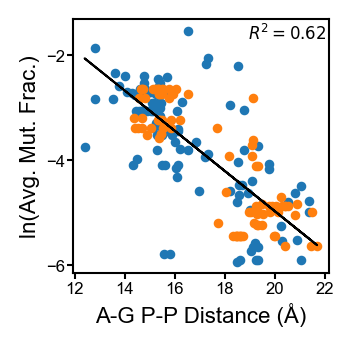

In [38]:
def plot_ag_correlation(df_corr_data, df_corr_new_data, df_pdb, ax):
    """
    Plots A-G P-P distance vs ln(Avg. Mut. Frac.) for both original and new data on the given axis.

    Args:
        df_corr_data (pd.DataFrame): Original correlation data.
        df_corr_new_data (pd.DataFrame): New correlation data.
        df_pdb (pd.DataFrame): DataFrame with PDB info to merge on 'pdb_id'.
        ax (matplotlib.axes.Axes): Axis to plot on.

    Returns:
        None
    """
    # get original data
    df_corr_data_ag = df_corr_data.query(
        'pair == "A-G" and atom1 == "P" and atom2 == "P"'
    ).copy()
    df_corr_data_ag.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "A-G P-P original data r2",
        get_r2(df_corr_data_ag["distance"], df_corr_data_ag["ln_r_data_mean"]),
    )
    print(f"A-G P-P number of original data points", len(df_corr_data_ag))
    df_corr_data_ag = df_corr_data_ag.merge(df_pdb, on="pdb_id")
    # get new data
    df_corr_new_data_ag = df_corr_new_data.query(
        'pair == "A-G" and atom_1 == "P" and atom_2 == "P"'
    ).copy()
    df_corr_new_data_ag.sort_values(by="distance", ascending=False, inplace=True)
    df_corr_new_data_ag = add_motif_indentifier_columns(
        df_corr_new_data_ag, "motif_name"
    )
    df_corr_new_data_ag = df_corr_new_data_ag.merge(df_pdb, on="pdb_id")
    print(
        "A-G P-P new data r2",
        get_r2(df_corr_new_data_ag["distance"], df_corr_new_data_ag["ln_reactivity"]),
    )
    print(f"A-G P-P number of new data points", len(df_corr_new_data_ag))
    # combine data
    df_combined_ag = combine_old_and_new_data(df_corr_data_ag, df_corr_new_data_ag)
    model = get_best_fit_line(df_combined_ag, "distance", "ln_r_data_mean")
    X = df_combined_ag["distance"].values.reshape(-1, 1)
    y = df_combined_ag["ln_r_data_mean"].values
    y_pred = model.predict(X)
    ax.scatter(df_corr_data_ag["distance"], df_corr_data_ag["ln_r_data_mean"], s=6)
    ax.scatter(
        df_corr_new_data_ag["distance"], df_corr_new_data_ag["ln_reactivity"], s=6
    )
    ax.plot(X, y_pred, color="black", linewidth=0.75)
    ax.set_xlabel("A-G P-P Distance (Å)", labelpad=2)
    ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_xticks([12, 14, 16, 18, 20, 22])
    print(
        "A-G P-P combined data r2",
        get_r2(df_combined_ag["distance"], df_combined_ag["ln_r_data_mean"]),
    )
    # Add R2 annotation in the top right corner
    r2_value = get_r2(df_combined_ag["distance"], df_combined_ag["ln_r_data_mean"])
    ax.text(
        0.99,
        0.99,
        f"$R^2 = {r2_value:.2f}$",
        transform=ax.transAxes,
        fontsize=6,
        fontname="Arial",
        verticalalignment="top",
        horizontalalignment="right",
    )
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_ag_correlation(df_corr_data, df_corr_new_data, df_pdb, ax)

C-A O3'-C2' original data r2 0.5139449403790022
C-A O3'-C2' new data r2 0.02751559379250192
C-A O3'-C2' combined data r2 0.29575642178439676


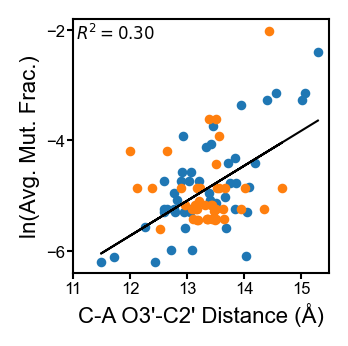

In [ ]:
def plot_ca_correlation(df_corr_data, df_corr_new_data, ax=None):
    """
    Plots the C-A O3'-C2' correlation using both original and new data, fits a regression line,
    and prints R^2 values.

    Args:
        df_corr_data (pd.DataFrame): Original correlation data.
        df_corr_new_data (pd.DataFrame): New correlation data.
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If None, creates new figure and axes.

    Returns:
        matplotlib.axes.Axes: The axes with the plot.
    """
    # get original data
    df_corr_data_ca = df_corr_data.query(
        'pair == "C-A" and atom1 == "O3\'" and atom2 == "C2\'"'
    ).copy()
    df_corr_data_ca.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "C-A O3'-C2' original data r2",
        get_r2(df_corr_data_ca["distance"], df_corr_data_ca["ln_r_data_mean"]),
    )
    # get new data
    df_corr_new_data_ca = df_corr_new_data.query(
        'pair == "C-A" and atom_1 == "O3\'" and atom_2 == "C2\'"'
    ).copy()
    df_corr_new_data_ca.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "C-A O3'-C2' new data r2",
        get_r2(df_corr_new_data_ca["distance"], df_corr_new_data_ca["ln_reactivity"]),
    )
    # combine data
    df_combined_ac = combine_old_and_new_data(df_corr_data_ca, df_corr_new_data_ca)
    model = get_best_fit_line(df_combined_ac, "distance", "ln_r_data_mean")
    X = df_combined_ac["distance"].values.reshape(-1, 1)
    y = df_combined_ac["ln_r_data_mean"].values
    y_pred = model.predict(X)
    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)
    ax.scatter(df_corr_data_ca["distance"], df_corr_data_ca["ln_r_data_mean"], s=6)
    ax.scatter(
        df_corr_new_data_ca["distance"], df_corr_new_data_ca["ln_reactivity"], s=6
    )
    ax.plot(X, y_pred, color="black", linewidth=0.75)
    ax.set_xlabel("C-A O3'-C2' Distance (Å)", labelpad=2)
    ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_xticks([11, 12, 13, 14, 15])
    ax.set_yticks([-6, -4, -2])
    r2_value = get_r2(df_combined_ac["distance"], df_combined_ac["ln_r_data_mean"])
    ax.text(
        0.01,
        0.99,
        f"$R^2 = {r2_value:.2f}$",
        transform=ax.transAxes,
        fontsize=6,
        fontname="Arial",
        verticalalignment="top",
        horizontalalignment="left",
    )
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    print(
        "C-A O3'-C2' combined data r2",
        get_r2(df_combined_ac["distance"], df_combined_ac["ln_r_data_mean"]),
    )
    return ax


# Example usage:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_ca_correlation(df_corr_data, df_corr_new_data, ax)l

C-C O3'-OP2' original data r2 0.6365635588287755
C-C O3'-OP2' new data r2 0.20752050535942115
C-C O3'-OP2' combined data r2 0.42652994558901103


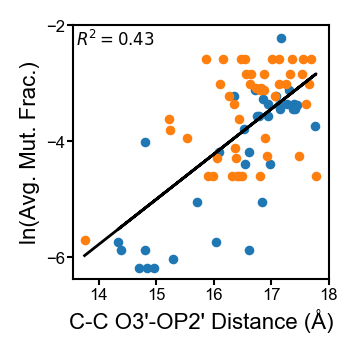

In [ ]:
def plot_cc_correlation(df_corr_data, df_corr_new_data, ax=None):
    """
    Plot C-C O3'-OP2' correlation using original and new data, fit line, and show R^2 in upper left.
    """
    # get original data
    df_corr_data_cc = df_corr_data.query(
        'pair == "C-C" and atom1 == "O3\'" and atom2 == "OP2"'
    ).copy()
    df_corr_data_cc.sort_values(by="distance", ascending=False, inplace=True)

    r2_orig = get_r2(df_corr_data_cc["distance"], df_corr_data_cc["ln_r_data_mean"])
    print("C-C O3'-OP2' original data r2", r2_orig)

    # get new data
    df_corr_data_new_cc = df_corr_new_data.query(
        'pair == "C-C" and atom_1 == "O3\'" and atom_2 == "O2P"'
    ).copy()
    df_corr_data_new_cc.sort_values(by="distance", ascending=False, inplace=True)

    r2_new = get_r2(
        df_corr_data_new_cc["distance"], df_corr_data_new_cc["ln_reactivity"]
    )
    print("C-C O3'-OP2' new data r2", r2_new)

    # combine data
    df_combined_cc = combine_old_and_new_data(df_corr_data_cc, df_corr_data_new_cc)
    model = get_best_fit_line(df_combined_cc, "distance", "ln_r_data_mean")
    X = df_combined_cc["distance"].values.reshape(-1, 1)
    y = df_combined_cc["ln_r_data_mean"].values
    y_pred = model.predict(X)

    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)
    ax.scatter(df_corr_data_cc["distance"], df_corr_data_cc["ln_r_data_mean"], s=6)
    ax.scatter(
        df_corr_data_new_cc["distance"], df_corr_data_new_cc["ln_reactivity"], s=6
    )
    ax.plot(X, y_pred, color="black", linewidth=1)
    ax.set_xlabel("C-C O3'-OP2' Distance (Å)", labelpad=2)
    ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_xticks([14, 15, 16, 17, 18])
    ax.set_yticks([-6, -4, -2])
    r2_combined = get_r2(df_combined_cc["distance"], df_combined_cc["ln_r_data_mean"])
    ax.text(
        0.01,
        0.99,
        f"$R^2 = {r2_combined:.2f}$",
        transform=ax.transAxes,
        fontsize=6,
        fontname="Arial",
        verticalalignment="top",
        horizontalalignment="left",
    )
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    print("C-C O3'-OP2' combined data r2", r2_combined)
    return ax


# Example usage:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_cc_correlation(df_corr_data, df_corr_new_data, ax)

A-G P-P original data r2 0.5068710179916264
A-G P-P number of original data points 122
A-G P-P new data r2 0.7257763761700462
A-G P-P number of new data points 91
A-G P-P combined data r2 0.6182110911930211
C-A O3'-C2' original data r2 0.5139449403790022
C-A O3'-C2' new data r2 0.02751559379250192
C-A O3'-C2' combined data r2 0.29575642178439676
C-C O3'-OP2' original data r2 0.6365635588287755
C-C O3'-OP2' new data r2 0.20752050535942115
C-C O3'-OP2' combined data r2 0.42652994558901103


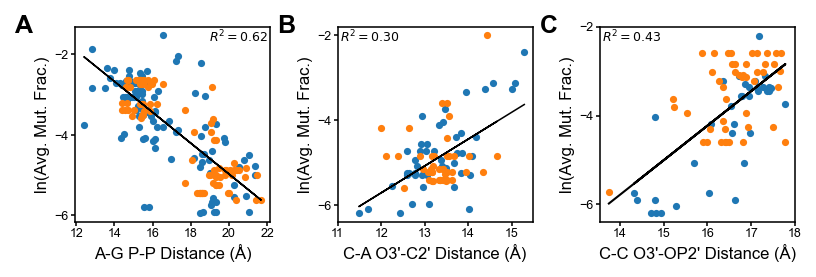

In [ ]:
fig_size = (7, 4)
layout = (1, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.30, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)

fig = plt.figure(figsize=fig_size, dpi=150)
ax1 = fig.add_axes(coords_list[0])
plot_ag_correlation(df_corr_data, df_corr_new_data, df_pdb, ax1)

ax2 = fig.add_axes(coords_list[1])
plot_ca_correlation(df_corr_data, df_corr_new_data, ax2)

ax3 = fig.add_axes(coords_list[2])
plot_cc_correlation(df_corr_data, df_corr_new_data, ax3)
add_subplot_labels(fig, coords_list[0:3])
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s21.png",
    dpi=600,
    bbox_inches="tight",
)